Problem 3 : Test DDPM on the mixture of 8 Gaussians and 25 Gaussians respectively.
These Gaussians can be either identical or with different parameters at your choice. You
should output figures like those in Problem 2.

Solution:

Importing the required libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt                                      
import torch
from sklearn.mixture import GaussianMixture
import torch.distributions as distribution
from matplotlib.patches import Ellipse
import torch
import torch.nn as nn
import torch.optim as optim

Defining the generic styling of plotting

In [ ]:
def hdr_plot_style():
    plt.style.use('dark_background')
    mpl.rcParams.update({'font.size': 18, 'lines.linewidth': 3, 'lines.markersize': 15})
    mpl.rcParams['ps.useafm'] = True
    mpl.rcParams['pdf.use14corefonts'] = True
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = 'Courier New'
    colors = mpl.cycler('color', ['#3388BB', '#EE6666', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
    plt.rc('legend', facecolor='#666666EE', edgecolor='white', fontsize=16)
    plt.rc('grid', color='white', linestyle='solid')
    plt.rc('text', color='white')
    plt.rc('xtick', direction='out', color='white')
    plt.rc('ytick', direction='out', color='white')
    plt.rc('patch', edgecolor='#E6E6E6')

Defining function that allows to generate a number of sub plots in a single line with the given titles

In [ ]:
def prep_plots(titles, fig_size, fig_num=1):
    hdr_plot_style()
    fig=plt.figure(fig_num, figsize=fig_size)
    ax_list = []
    for ind, title in enumerate(titles, start=1):
        ax=fig.add_subplot(1, len(titles), ind)
        ax.set_title(title)
        ax_list.append(ax)
    return ax_list

Adding grid and legend to all axes in the given list

In [ ]:
def finalize_plots(axes_list, legend=True, fig_title=None):
    if fig_title:
        fig = axes_list[0].figure
        fig.suptitle(fig_title, y=1)
    for ax in axes_list:
        ax.grid(True)
        if legend:
            ax.legend()

Plotting the decision boundary of a single neuron with 2-dimensional inputs

In [ ]:
def plot_patterns(P,D):
    hdr_plot_style()
    nPats = P.shape[1]
    nUnits = D.shape[0]
    if nUnits < 2:
        D = np.concatenate(D, np.zeros(1,nPats)) 
    fig = plt.figure(figsize=(10, 8))
    ax = plt.gca()
    xmin, xmax = np.min(P[0, :]), np.max(P[0, :])
    xb = (xmax - xmin) * 0.2
    ymin, ymax = np.min(P[1, :]), np.max(P[1, :])
    yb = (ymax-ymin) * 0.2
    ax.set(xlim=[xmin-xb, xmax+xb], ylim=[ymin-yb, ymax+yb])
    plt.title('Input Classification')
    plt.xlabel('x1'); plt.ylabel('x2')
    colors = [[0, 0.2, 0.9], [0, 0.9, 0.2], [0, 0, 1], [0, 1, 0]]
    symbols = 'ooo*+x'; Dcopy = D[:]
    for i in range(nPats):
        c = Dcopy[i]
        ax.scatter(P[0,i], P[1,i], marker=symbols[c], c=colors[c], s=50, linewidths=2, edgecolor='w')
    ax.grid(True)
    return fig

Plotting (bi-dimensionnal) input patterns 

In [ ]:
def plot_boundary(W,iVal,style,fig):
    nUnits = W.shape[0]
    colors = plt.cm.inferno_r.colors[1::3]
    xLims = plt.gca().get_xlim()
    for i in range(nUnits):
        if len(style) == 1:
            color = [1, 1, 1];
        else:
            color = colors[int((3 * iVal + 9) % len(colors))]
        plt.plot(xLims,(-np.dot(W[i, 1], xLims) - W[i, 0]) / W[i, 2], linestyle=style, color=color, linewidth=1.5);
        fig.canvas.draw()

Defination for plotting a linear decision boundary learned by the Suport vector machine

In [ ]:
def visualize_boundary_linear(X, y, model):
    hdr_plot_style()
    w = model["w"]
    b = model["b"]
    xp = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100).transpose()
    yp = - (w[0] * xp + b) / w[1]
    plt.figure(figsize=(12, 8))
    pos = (y == 1)[:, 0] 
    neg = (y == -1)[:, 0]
    plt.scatter(X[pos, 0], X[pos, 1], marker='x', linewidths=2, s=23, c=[0, 0.5, 0])
    plt.scatter(X[neg, 0], X[neg, 1], marker='o', linewidths=2, s=23, c=[1, 0, 0])
    plt.plot(xp, yp, '-b')
    plt.scatter(model["X"][:, 0], model["X"][:, 1], marker='o', linewidths=4, s=40, c=None, edgecolors=[0.1, 0.1, 0.1])

Defination for Plotting the data points X and y into a new figure 

In [ ]:
def plot_data(X, y):
    hdr_plot_style()
    pos = (y == 1)[:, 0] 
    neg = (y == 0)[:, 0]
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(X[pos, 0], X[pos, 1], marker='x', edgecolor='k', linewidths=2, s=50, c=[0, 0.5, 0])
    plt.scatter(X[neg, 0], X[neg, 1], marker='o', edgecolor='k', linewidths=2, s=50, c=[1, 0, 0])
    return fig

Defination plots a non-linear decision boundary learned by the Support Vector machine

In [ ]:
def visualize_boundary(X, y, model):
    hdr_plot_style()
    plot_data(X, y)
    x1plot = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100).transpose()
    x2plot = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100).transpose()
    [X1, X2] = np.meshgrid(x1plot, x2plot)
    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        this_X = np.vstack((X1[:, i], X2[:, i]))
        vals[:, i] = svmPredict(model, this_X)
    plt.contour(X1, X2, vals, [1, 1], c='b')
    plt.scatter(model["X"][:, 0], model["X"][:, 1], marker='o', linewidths=4, s=10, c=[0.1, 0.1, 0.1])

Plotting the decision function for a 2D SVC

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    ax.contour(X, Y, P, colors='w',
               levels=[-1, 0, 1], alpha=0.9,
               linestyles=['--', '-', '--'])
    
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=2, edgecolor='w', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Defination for plotting 2-d and 3-d Gaussian distributions

In [ ]:
def plot_gaussian_ellipsoid(m, C, sdwidth=1, npts=None, axh=None, color='r'):
    if axh is None:
        axh = plt.gca()
    if m.size != len(m): 
        raise Exception('M must be a vector'); 
    if (m.size == 2):
        h = show2d(m[:], C, sdwidth, npts, axh, color)
    elif (m.size == 3):
        h = show3d(m[:], C, sdwidth, npts, axh, color)
    else:
        raise Exception('Unsupported dimensionality');
    return h

Showing the figure in 2D

In [ ]:
def show2d(means, C, sdwidth, npts=None, axh=None, color='r'):
    if (npts is None):
        npts = 50
    tt = np.linspace(0, 2 * np.pi, npts).transpose()
    x = np.cos(tt);
    y = np.sin(tt);
    ap = np.vstack((x[:], y[:])).transpose()
    v, d = np.linalg.eigvals(C)
    d = sdwidth / np.sqrt(d)
    bp = np.dot(v, np.dot(d, ap)) + means
    h = axh.plot(bp[:, 0], bp[:, 1], ls='-', color=color)
    return h

Showing the figure in 3D

In [ ]:
def show3d(means, C, sdwidth, npts=None, axh=None):
    if (npts is None):
        npts = 20
    x, y, z = sphere(npts);
    ap = np.concatenate((x[:], y[:], z[:])).transpose()
    v, d = eigvals(C)
    if any(d[:] < 0):
        print('warning: negative eigenvalues')
        d = np.max(d, 0)
    d = sdwidth * np.sqrt(d); 
    bp = (v * d * ap) + repmat(means, 1, size(ap,2)); 
    xp = reshape(bp[0,:], size(x));
    yp = reshape(bp[1,:], size(y));
    zp = reshape(bp[2,:], size(z));
    h = axh.surf(xp, yp, zp);
    return h

Defining Fit Multivariate Gaussian

In [ ]:
def fit_multivariate_gaussian(X_s):
    gmm = GaussianMixture(n_components=8).fit(X_s)
    labels = gmm.predict(X_s)
    N = 50
    X = np.linspace(-2, 10, N)
    Y = np.linspace(-4, 4, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    norm = distribution.MultivariateNormal(torch.Tensor(gmm.means_[0]), torch.Tensor(gmm.covariances_[0]))
    Z = torch.exp(norm.log_prob(torch.Tensor(pos))).numpy()
    plt.figure(figsize=(10, 8));
    ax = plt.gca()
    cset = ax.contourf(X, Y, Z, cmap='magma')
    plt.scatter(X_s[:, 0], X_s[:, 1], c='b', s=60, edgecolor='w', zorder=2.5); plt.grid(True);
    return labels

***Defination of Fit gaussioan Mixture with 4 - Gaussian***


In [ ]:
def fit_gaussian_mixture(X_s):
    gmm = GaussianMixture(n_components=8).fit(X_s)
    labels = gmm.predict(X_s)
    N = 50
    X = np.linspace(-2, 10, N)
    Y = np.linspace(-4, 4, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z = np.zeros((pos.shape[0], pos.shape[1]))
    for i in range(4):
        norm = distribution.MultivariateNormal(torch.Tensor(gmm.means_[i]), torch.Tensor(gmm.covariances_[i]))
        Z += torch.exp(norm.log_prob(torch.Tensor(pos))).numpy()
    plt.figure(figsize=(10, 8));
    ax = plt.gca()
    cset = ax.contourf(X, Y, Z, cmap='magma')
    plt.scatter(X_s[:, 0], X_s[:, 1], c='b', s=60, edgecolor='w', zorder=2.5); plt.grid(True);
    return labels

Drawing an ellipse with a given position and covariance

In [ ]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

Plotting GMM

In [ ]:
def plot_gmm(gmm, X, label=True, ax=None):
    plt.figure(figsize=(10,8))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='magma', edgecolor='gray', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.4 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

Calling the helper plot

In [ ]:
hdr_plot_style()

**Importing sample batch from the swiss roll**

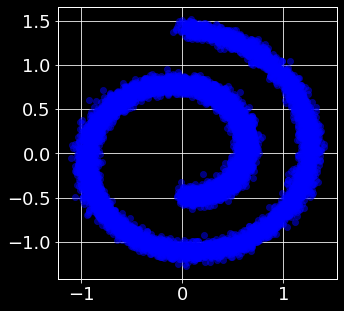

In [ ]:
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
data = sample_batch(10**4).T
plt.figure(figsize=(5, 5))
plt.scatter(*data, alpha=0.5, color='blue', edgecolor='blue', s=40);

Inporting the torch library and loss calculation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    norm_loss = (logp * vectors) ** 2 / 2.
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

Defining denoising score matching

In [ ]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

working on approximation model


In [ ]:
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)

Creating ADAM optimizer over our model which we created

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
for t in range(5000):
    loss = denoising_score_matching(model, dataset)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if ((t % 1000) == 0):
        print(loss)

tensor(10002.9180, grad_fn=<MulBackward0>)
tensor(9956.5586, grad_fn=<MulBackward0>)
tensor(10061.4844, grad_fn=<MulBackward0>)
tensor(9860.0039, grad_fn=<MulBackward0>)
tensor(9945.2295, grad_fn=<MulBackward0>)


Defining the plot gradients value

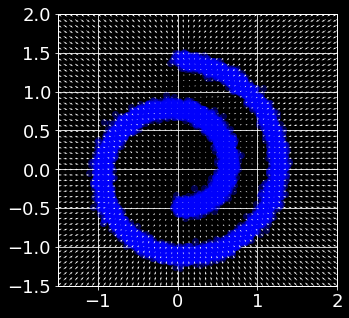

In [ ]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.from_numpy(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(5,5))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='blue', edgecolor='blue', s=40)
    plt.quiver(xx.T[0], xx.T[1], scores_log1p[:,0], scores_log1p[:,1], width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

Defining Sample langevin values

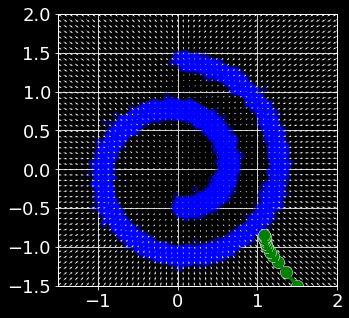

In [ ]:
def sample_langevin(model, x, n_steps=10, eps=1e-3, decay=.9, temperature=1.0):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_langevin(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / torch.tensor(np.linalg.norm(deltas, keepdims=True, axis=-1)) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

**The Forward trajectory q(Xo:T)**

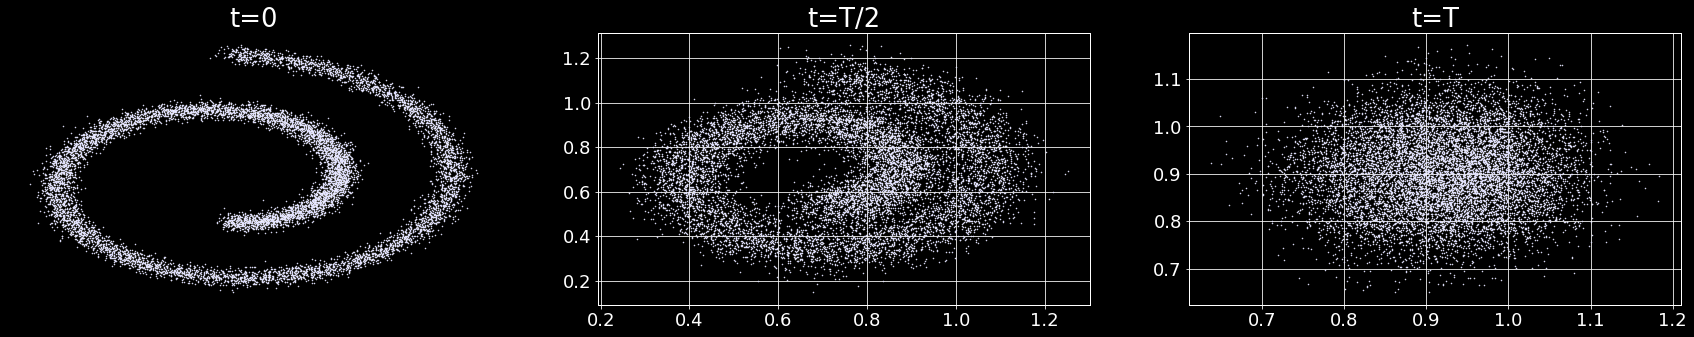

In [ ]:
def forward_process(x_start, n_steps, noise=None):
    x_seq = [x_start]
    for n in range(n_steps):
        x_seq.append((torch.sqrt(1 - betas[n]) * x_seq[-1]) + (betas[n] * torch.rand_like(x_start)))
    return x_seq
n_steps = 200
betas = torch.tensor([0.035] * n_steps)
dataset = torch.Tensor(data.T).float()
x_seq = forward_process(dataset, n_steps, betas)
fig, axs = plt.subplots(1, 3, figsize=(30, 5))
for i in range(3):
    axs[i].scatter(x_seq[int((i / 3.0) * n_steps)][:, 0], x_seq[int((i / 3.0) * n_steps)][:, 1],color='blue', edgecolor='white', s=1);
    if i == 0:
      axs[0].set_axis_off(); axs[i].set_title('t=0')
    if i == 1:
      axs[0].set_axis_off(); axs[i].set_title('t=T/2')
    if i == 2:
      axs[0].set_axis_off(); axs[i].set_title('t=T')

**The Reverse trajectory p(Xo:T)**

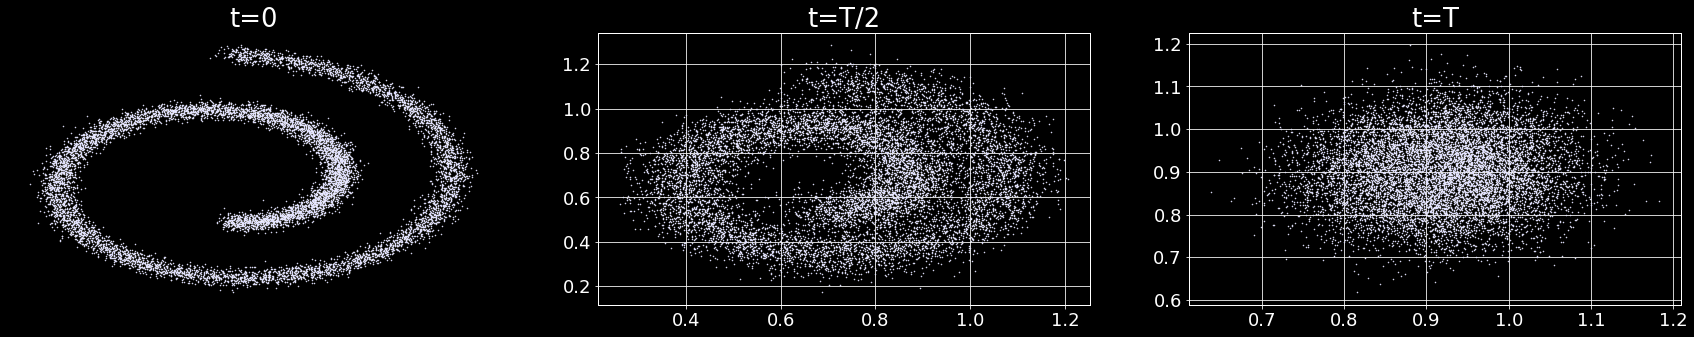

In [ ]:
def reverse_process(x_start, n_steps, noise=None):
    x_seq = [x_start]
    for n in range(n_steps):
        x_seq.append((torch.sqrt(1 - betas[n]) * x_seq[-1]) + (betas[n] * torch.rand_like(x_start)))
    return x_seq
n_steps = 200
betas = torch.tensor([0.035] * n_steps)
dataset = torch.Tensor(data.T).float()
x_seq = reverse_process(dataset, n_steps, betas)
fig, axs = plt.subplots(1, 3, figsize=(30, 5))
for i in range(3):
    axs[i].scatter(x_seq[int((i / 3.0) * n_steps)][:, 0], x_seq[int((i / 3.0) * n_steps)][:, 1],color='blue', edgecolor='white', s=1);
    if i == 0:
      axs[0].set_axis_off(); axs[i].set_title('t=0')
    if i == 1:
      axs[0].set_axis_off(); axs[i].set_title('t=T/2')
    if i == 2:
      axs[0].set_axis_off(); axs[i].set_title('t=T')